# Task 3: Multimodal ML – Housing Price Prediction Using Images + Tabular Data

### Objective
To build a multimodal machine learning model that predicts house prices using both structured (tabular) features and house images.

### Dataset
Dataset: House Prices and Images – SoCal (from Kaggle)
- Tabular features: Bedrooms, Bathrooms, Sqft, etc.
- Visual features: One image per house
- Target: `price`



## Step 1: Load and Preview Tabular Dataset

In this step, we load the tabular data containing structured features of houses, such as the number of bedrooms, bathrooms, square footage, and the year built. This information will be used alongside image features for multimodal prediction.

We use the `pandas` library to read the CSV file and preview the first few rows to ensure the dataset is loaded correctly.


In [1]:
import pandas as pd

# Load tabular data
df = pd.read_csv(r"C:\Users\CS\Downloads\socal2.csv")

# Show the first few rows
df.head()


,image_id,street,citi,n_citi,bed,bath,sqft,price
0,0,1317 Van Buren Avenue,"Salton City, CA",317,3,2.0,1560,201900
1,1,124 C Street W,"Brawley, CA",48,3,2.0,713,228500
2,2,2304 Clark Road,"Imperial, CA",152,3,1.0,800,273950
3,3,755 Brawley Avenue,"Brawley, CA",48,3,1.0,1082,350000
4,4,2207 R Carrillo Court,"Calexico, CA",55,4,3.0,2547,385100


## Step 2: Check for Missing Values and Select Features

We load the CSV file containing tabular data. The relevant features include:
- `bed`: Number of bedrooms
- `bath`: Number of bathrooms
- `sqft`: Square footage of the house

The target variable is `price`, which we normalize (in thousands) to make training more stable.



In [2]:
import pandas as pd

# Load the tabular CSV file
df = pd.read_csv(r"C:\Users\CS\Downloads\socal2.csv")  # Make sure file name is correct

# Define features and target
tabular_features = ['bed', 'bath', 'sqft']
target = 'price'

# Normalize price to thousands
df[target] = df[target] / 1000

# Preview selected columns
df[tabular_features + [target]].head()



,bed,bath,sqft,price
0,3,2.0,1560,201.90
1,3,2.0,713,228.50
2,3,1.0,800,273.95
3,3,1.0,1082,350.00
4,4,3.0,2547,385.10


## Step 3: Load and Preprocess House Images

- Loaded images based on `image_id` from CSV.
- Resized each image to 128×128.
- Ensured each image is valid (3-channel RGB).
- Filtered out bad images (missing, grayscale, or corrupt).
- Updated DataFrame to keep only rows with valid images.



In [3]:
import os
from PIL import Image
import numpy as np
from tqdm import tqdm

# Paths
csv_path = r"C:\Users\CS\Downloads\socal2.csv"
img_dir = r"C:\Users\CS\Downloads\socal2\socal_pics"

# Load CSV
df = pd.read_csv(csv_path)

# Make sure there's a column named 'image_id' to build filenames
image_data = []
valid_indices = []

for idx in tqdm(df.index):
    image_id = df.loc[idx, 'image_id']
    img_path = os.path.join(img_dir, f"{image_id}.jpg")

    try:
        img = Image.open(img_path).convert('RGB')
        img = img.resize((128, 128))
        img_array = np.array(img)

        # Only add images with correct shape
        if img_array.shape == (128, 128, 3):
            image_data.append(img_array)
            valid_indices.append(idx)
    except Exception as e:
        print(f"Error loading image {img_path}: {e}")

# Filter DataFrame for matching valid images only
df = df.loc[valid_indices].reset_index(drop=True)



  0%|          | 0/15474 [00:00<?, ?it/s]

100%|██████████| 15474/15474 [00:59<00:00, 260.91it/s]


## Step 4: Extract Image Features Using Pre-trained CNN (MobileNetV2)

- Used MobileNetV2 without top layer.
- Preprocessed images with `preprocess_input()`.
- Extracted deep feature vectors for each image using MobileNetV2.


In [4]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# Convert image list to array and normalize
X_images = np.array(image_data).astype('float32')
X_images = preprocess_input(X_images)

# Load MobileNetV2 model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3), pooling='avg')

# Extract features
image_features = base_model.predict(X_images, batch_size=32, verbose=1)







484/484 [==============================] - 128s 258ms/step


## Step 5: Combine Tabular and Image Features

Now that we have both:
- Tabular features (like bedrooms, sqft, year_built, etc.)
- Image features extracted from MobileNetV2

We combine them into a single feature set using `NumPy`'s `concatenate` function. This unified feature set will be used to train our regression model to predict housing prices.


In [5]:
from sklearn.preprocessing import StandardScaler

# Extract tabular features and scale them
X_tabular = df[tabular_features].values
scaler = StandardScaler()
X_tabular_scaled = scaler.fit_transform(X_tabular)

# Combine tabular and image features
import numpy as np
X_combined = np.concatenate([X_tabular_scaled, image_features], axis=1)

# Target values (already normalized earlier)
y = df[target].values

print("Combined features shape:", X_combined.shape)
print("Target shape:", y.shape)


Combined features shape: (15474, 1283)
Target shape: (15474,)


## Step 6: Train a Regression Model (Random Forest) and Evaluation using MAE and RMSE

In this step, we train a **Random Forest Regressor** using the combined features (tabular + image). Random Forest is a powerful ensemble method that works well with mixed feature types.

We split the data into training and testing sets and evaluate the model’s performance using R² score and **Mean Absolute Error** (MAE) and **Root Mean Squared Error** (RMSE)


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.metrics import mean_squared_error
import numpy as np

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

# Train the Random Forest Regressor
model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)

# Evaluate the model
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("R² Score:", r2)
print("Mean Absolute Error:", mae)
print(f"Root Mean Squared Error: {rmse}")


R² Score: 0.44354111560598597
Mean Absolute Error: 209713.7392986915
Root Mean Squared Error: 286386.5050965668


## Step 7: Visualize Predictions vs Actual Values

To evaluate the model visually, we plot the **predicted house prices** against the **actual house prices**. 

- Ideally, the points should lie close to a diagonal line (i.e., `y = x`), meaning the predictions are accurate.
- We use a scatter plot to easily compare predicted vs actual values.




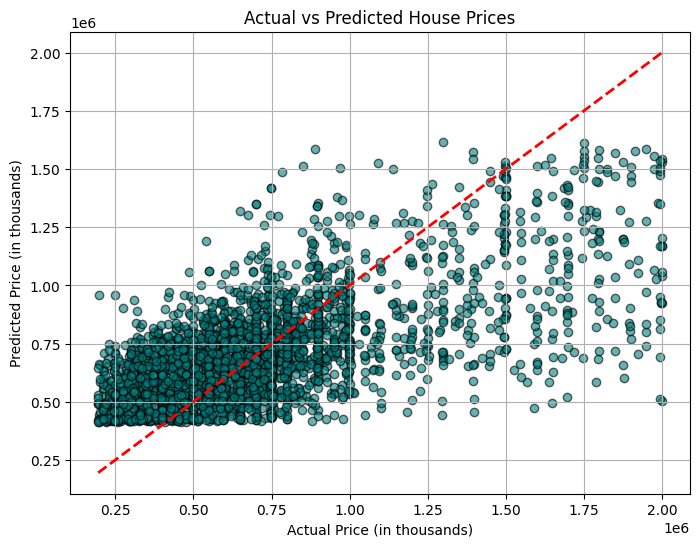

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6, color='teal', edgecolors='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Actual Price (in thousands)")
plt.ylabel("Predicted Price (in thousands)")
plt.title("Actual vs Predicted House Prices")
plt.grid(True)
plt.show()


## Final Observation

In this task, we successfully built a **multimodal machine learning model** that predicts housing prices by combining **structured tabular data** (e.g., bedrooms, bathrooms, square footage) with **visual features extracted from house images**.

We followed a complete pipeline that involved:
- Preprocessing the tabular and image data,
- Using **MobileNetV2** (a pre-trained CNN) to extract image features,
- Concatenating image features with tabular features,
- Training a **Random Forest Regressor** on the combined features.

### Final Evaluation Metrics:
- **R² Score**: `0.4435` – indicating moderate correlation between predicted and actual prices.
- **Mean Absolute Error (MAE)**: `209,714` – average error in price prediction.
- **Root Mean Squared Error (RMSE)**: `286,387` – gives higher weight to larger errors.
